# Aula 2

---

**Saulo Martiello Mastelini**<br>
Candidato a Ph.D. pelo ICMC-USP<br>
Online Machine Learning

Página pessoal: [smastelini](https://smastelini.github.io/)</br>
e-mail: saulomastelini@gmail.com

---

## Sumário:

- Algoritmos baseados em distância
- Particionamento de dados para avaliação: Holdout e Holdout repetido
- Métricas de avaliação para classificação

---

In [1]:
import abc  # Classes abstratas (mais sobre isso depois)

import numpy as np   # Math
import pandas as pd  # Dados

import plotly.express as px  # Plots
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification  # Geração de datasets
from sklearn import metrics  # Metrics
from sklearn.model_selection import train_test_split  # Split dos dados

## 1. Contextualização

Vamos definir alguns vetores para teste:

In [2]:
a = np.array([1, 2])
b = np.array([2, 3])
c = np.array([3, 5])

- Precisamos definir a nossa noção de distância
- Exemplos
- Com o que estamos lidando aqui?

In [3]:
fig = px.scatter(x=[a[0], b[0], c[0]], y=[a[1], b[1], c[1]])
fig.update_layout(
    autosize=False,
    width=600,
    height=500
)
fig.show()

- Espaço 2D
    - Tipicamente lidamos com espaços N-dimensionais
- Precisamos de medidas para calcular distâncias
- Vamos começar com uma métrica de distância muito famosa: Distância Euclidiana
    - $dist_{l2}(\vec{u}, \vec{v}) = \sqrt{\sum_i^n (u_i - v_i) ^2}$
- Vamos usar o numpy para nos ajudar com as funções matemáticas necessárias

In [4]:
def euclidean_dist(v1, v2):
    sq_diff = (v1 - v2) ** 2

    # Condicional para tratar tanto vetores quanto matrizes
    if len(v1.shape) > 1:
        sq_diff = np.sum(sq_diff, axis=1)
    else:
        sq_diff = np.sum(sq_diff)
    return sq_diff ** 0.5


In [5]:
euclidean_dist(a, b)

1.4142135623730951

In [6]:
euclidean_dist(a, c)

3.605551275463989

In [7]:
euclidean_dist(b, c)

2.23606797749979

- Podemos tirar proveito da vetorização!
    - O que é isso?

In [8]:
d = np.array([[1, 2], [3, 4]])
d.shape

(2, 2)

In [9]:
d

array([[1, 2],
       [3, 4]])

In [10]:
euclidean_dist(d, a)

array([0.        , 2.82842712])

**Cenário mais realístico - parte 1**

- Vamos imaginar um cenário mais prático
- Vários pontos num espaço N-dimensional (o nosso dataset)


In [11]:
e = np.array(
    [
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 7],
        [3, 5, 2]
    ]
)
e

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 7],
       [3, 5, 2]])

In [12]:
fig = px.scatter_3d(x=e[:, 0], y=e[:, 1], z=e[:, 2])
fig.update_layout(
    autosize=False,
    width=600,
    height=500
)
fig.show()

In [13]:
euclidean_dist(e, np.array([1.5, 2.9, 8.0]))

array([5.10489961, 4.03236903, 2.11187121, 6.53146232])

In [14]:
e

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 7],
       [3, 5, 2]])

In [15]:
def manhattan_dist(v1, v2):
    abs_diff = np.abs(v1 - v2)

    # Condicional para tratar tanto vetores quanto matrizes
    if len(v1.shape) > 1:
        abs_diff = np.sum(abs_diff, axis=1)
    else:
        abs_diff = np.sum(abs_diff)
    return abs_diff


- Outra alternativa é a distância Manhattan:
    - $dist_{l1}(\vec{u}, \vec{v}) = \sum_i^n |u_i - v_i|$
- Podemos generalizar várias medidas de distância através da distância Minkowski:
    - $dist_{lp}(\vec{u}, \vec{v}) = (\sum_i^n |u_i - v_i| ^ p) ^ \frac{1}{p}$
- A distância cosseno é útil em aplicações que utilizam dados textuais:
    - $dist_{\cos} = \cos(\theta) = \dfrac{\vec{u} \cdot \vec{v}}{\|\vec{u}\|\|\vec{u}\|} = \dfrac{\sum_i^n u_i v_i}{\sqrt{\sum_i^n u_i ^ 2}\sqrt{\sum_i^n v_i ^ 2}}$

In [16]:
manhattan_dist(e, np.array([1.5, 2.9, 8.0]))

array([6.4, 4.6, 3.6, 9.6])

**Cenário mais realístico - parte 2**

- Cada ponto tem uma medida de interesse que queremos prever para observações futuras
    - Classificação
    - Regressão


## 2. k-Nearest Neighbors

- k-Vizinhos mais próximos:
    - Calcula a distância de novos pontos para a base de dados
    - Utiliza a informação dos $k$ vizinhos mais próximos para obter a resposta final 
- Algoritmo _lazy_ ou preguiçoso
    - Por quê?


In [17]:
dists = np.array([1.2, 3.1, 5., 8.3, 2.5])
dists

array([1.2, 3.1, 5. , 8.3, 2.5])

In [18]:
labels = np.array([0, 0, 1, 0, 1])

In [19]:
ordenado = np.argsort(dists)
ordenado

array([0, 4, 1, 2, 3])

In [20]:
top_3 = ordenado[:3]
top_3

array([0, 4, 1])

In [21]:
labels[top_3]

array([0, 1, 0])

In [22]:
aux = np.bincount(labels[top_3])
aux

array([2, 1])

In [23]:
np.argmax(aux)

0

In [24]:
class BaseKNN(abc.ABC):
    def __init__(self, k, p, verbose):
        self.k = k
        self.p = p
        self.verbose = verbose

        assert isinstance(k, int) and k >= 1

    def _minkowski_dist(self, x_new):
        return np.sum(np.abs(self._X - x_new) ** self.p, axis=1) ** (1 / self.p)
    
    # Treina o modelo
    def fit(self, X, y):
        if self.verbose:
            print("Vou fingir que trabalho.")

        self._X = X
        self._y = y

        if self.verbose:
            print("\tUfa, que canseira!")

        return self

    @abc.abstractmethod
    def predict(self, X_new):
        pass


class KNNClassifier(BaseKNN):
    def __init__(self, k=3, p=2, verbose=False):
        super().__init__(k, p, verbose)
    
    def predict(self, X_new):
        y_pred = np.zeros(len(X_new), dtype=int)

        if self.verbose:
            print("Hora de predizer:")

        for i in range(len(X_new)):
            dists = self._minkowski_dist(X_new[i, :])
            order = np.argsort(dists)
            top_k = order[:self.k]

            # A classificação acontece aqui
            y_pred[i] = np.argmax(np.bincount(self._y[top_k]))

            if self.verbose:
                print(f"Instância de predição {i} | Vizinhos mais próximos: {top_k} | R: {y_pred[i]}")

        return y_pred
    

class KNNRegressor(BaseKNN):
    def __init__(self, k=3, p=2, verbose=False):
        super().__init__(k, p, verbose)
    
    def predict(self, X_new):
        y_pred = np.zeros(len(X_new))

        if self.verbose:
            print("Hora de predizer:")

        for i in range(len(X_new)):
            dists = self._minkowski_dist(X_new[i, :])
            order = np.argsort(dists)
            top_k = order[:self.k]

            # A regressão acontece aqui
            y_pred[i] = np.mean(self._y[top_k])

            if self.verbose:
                print(f"Instância de predição {i} | Vizinhos mais próximos: {top_k} | R: {y_pred[i]}")

        return y_pred


In [25]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=0
)

In [26]:
vis = pd.DataFrame(X, columns=["x1", "x2"])
vis["Classe"] = y
vis["Classe"] = vis["Classe"].astype("category")

fig = px.scatter(
    vis, x="x1", y="x2", color="Classe", symbol="Classe")
fig.update_layout(
    autosize=False,
    width=600,
    height=500
)
fig.show()

---
## 3. Notas sobre avaliação de modelos de ML, _overfitting_, _undefitting_.

- Não podemos utilizar todos os dados disponíveis num primeiro momento
- Precisamos ter uma estimativa de performance do nosso modelo treinado

- > **Desafio:** Por que utilizar todos os dados os dados para treinar e testar é uma má ideia?


### 3.1. Sobre e subajuste de modelos

- Queremos que o modelo seja capaz de generalizar os dados de treinamento
    - Aprender os padrões que governam a relação entre X e y
    - Na vida é assim:
        - Não podemos focar demais nos detalhes insignificantes
        - Tampouco sermos superficiais demais


<img src="img/a2/tradeoff.jpg" width="700">
    <figcaption>Overfitting, underfitting e o dilema do Viés e Variância. Fonte: <a href="https://stats.stackexchange.com/questions/543509/why-test-error-and-variance-has-different-curve-in-bias-variance-trade-off-graph)">stats.stackexchange.com</a></figcaption>
</img>

Os dois desafios a se evitar durante a modelagem:

1. Overfitting: O modelo está focando demais em excesso nos dados de treinamento e não está aprendendo, de fato, o problema
    - O modelo demasiadamente complexo e sem estratégias de regularização (algo como um sistema de frenagem, que limita a "velocidade")
    - Ex: estudante que decora toda a matéria, mas se na prova algum detalhe é diferente, não sabe resolver
    - Alta variância: pequenas alterações nos dados acarretam grandes mudanças no modelo
    - *Sintomas:*
        - Erro de treinamento muito baixo
        - Erro de teste muito alto
    - Observação: se o seu erro de testes está bom demais para ser verdade:
        - Pode ser que exista _"data leakage"_
        - Dados de teste estão vazando para o treinamento
2. Undefitting: O modelo não está conseguindo aprender os padrões
    - Modelo demasiadamente simples para o problema
    - Ex: uma reta para explicar o comportamento de uma parábola
    - Alto viés: o modelo é "teimoso" e insensível a variações dos dados
    - *Sintomas:*
        - Erros de validação/teste e treinamento são parecidos (e altos)


- Queremos um balanço:
- Em geral:
    - Erro de treino ligeiramente inferior que o erro de validação
    - Baixo erro de validação

---

### 3.2. Particionamento de dados: _Holdout_

- Em geral, utilizamos alguma estratégia de avaliação para separar os dados entre treinamento e teste/validação
    - Obter medidas de avaliação mais fidedignas com a realidade que o modelo vai enfrentar na "vida real"
- Holdout: Aplica uma partição (aleatória) entre os dados para criar conjuntos de treino e teste
    - Normalmente baseada em porcentagem. Por exemplo: 30% dos dados serão utilizados para testes

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [28]:
X.shape, X_train.shape, X_test.shape

((200, 2), (140, 2), (60, 2))

In [29]:
y.shape, y_train.shape, y_test.shape

((200,), (140,), (60,))

In [30]:
X

array([[ 1.20120424,  2.68585849],
       [-0.47565612,  1.27888341],
       [ 1.85445232,  0.02177088],
       [ 0.12692666,  0.02418069],
       [-0.98887301,  0.78891079],
       [-1.84733219,  0.7181598 ],
       [-2.27039869,  0.7146886 ],
       [ 1.56968042, -2.34787726],
       [ 1.00671517,  0.62443754],
       [-0.87432656,  0.71681344],
       [ 0.52276605, -0.7188685 ],
       [ 0.96815935, -0.91566499],
       [ 0.02271892,  1.73743499],
       [ 1.35360805,  1.67300665],
       [-0.21360694,  1.32166991],
       [-2.13163526,  0.41254111],
       [ 0.76253223,  1.61199303],
       [-0.66716811,  1.27256807],
       [ 0.13738716,  2.63339007],
       [-1.10271319, -2.81899406],
       [ 1.98734896, -0.56250671],
       [ 2.28166504, -0.35061669],
       [ 0.68050218, -0.79675418],
       [-0.18493983,  1.80714016],
       [-2.28810495,  0.626327  ],
       [-1.2607126 ,  0.8950888 ],
       [ 1.0069467 , -0.06671705],
       [ 0.84121147,  1.57291492],
       [ 1.7574514 ,

In [31]:
y

array([1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2,
       2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 1, 2, 2, 0,
       1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2,
       0, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0,
       0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0,
       1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0,
       2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1,
       1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 2,
       0, 0])

> **Para pensar:** quais as limitações dessa abordagem?

Possível solução:

- Holdout repetido:
    - Aplica várias partições holdout, variando a seed aleatória
    - Modelos treinados para cada partição
    - Agrega os resultados obtidos: média, desvio padrão, etc.
- Qual a limitação dessa abordagem? (Ela resolve o problema parcialmente, mas o que ainda falta?)
- No decorrer do curso veremos abordagens mais adequadas para avaliação


### 3.2. Aplicando o Holdout no nosso modelo k-NN para classificação

In [32]:
knn_c = KNNClassifier(verbose=True)
knn_c.fit(X_train, y_train)

pass

Vou fingir que trabalho.
	Ufa, que canseira!


In [33]:
y_pred = knn_c.predict(X_test)

Hora de predizer:
Instância de predição 0 | Vizinhos mais próximos: [23  1  2] | R: 1
Instância de predição 1 | Vizinhos mais próximos: [47 25 37] | R: 0
Instância de predição 2 | Vizinhos mais próximos: [ 81 136 114] | R: 0
Instância de predição 3 | Vizinhos mais próximos: [ 17  65 120] | R: 0
Instância de predição 4 | Vizinhos mais próximos: [ 54  92 138] | R: 2
Instância de predição 5 | Vizinhos mais próximos: [ 58  89 128] | R: 0
Instância de predição 6 | Vizinhos mais próximos: [85 82 26] | R: 0
Instância de predição 7 | Vizinhos mais próximos: [47 37 25] | R: 0
Instância de predição 8 | Vizinhos mais próximos: [83 64 58] | R: 0
Instância de predição 9 | Vizinhos mais próximos: [60 77 61] | R: 1
Instância de predição 10 | Vizinhos mais próximos: [44 36 95] | R: 0
Instância de predição 11 | Vizinhos mais próximos: [15 40  4] | R: 0
Instância de predição 12 | Vizinhos mais próximos: [13 34 30] | R: 2
Instância de predição 13 | Vizinhos mais próximos: [ 10 120  79] | R: 0
Instância d

In [34]:
y_pred

array([1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 0, 0,
       2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 0, 2, 2, 2])

In [35]:
y_test

array([1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0,
       2, 0, 2, 2, 0, 0, 1, 2, 0, 1, 1, 2, 0, 2, 2, 1])

## 4. Métricas de avaliação para classificação

- Permitem avaliar o modelo preditivo
- Várias métricas, a depender da necessidade
- **Acurácia:** percentual de acerto

In [36]:
def acuracia(y_true, y_pred):
    return sum(y_true == y_pred) / len(y_true)

In [37]:
acuracia(y_test, y_pred)

0.8833333333333333

- A acurácia pode ser problemática
- Suponha que tenhamos um cenário altamente desbalanceado
    - A proporção de exemplos de cada classe é altamente desigual

In [38]:
ex = np.zeros(100, dtype=int)
ex[3] = 1
ex[10] = 1
ex[39] = 1

acuracia(ex, np.zeros(100))


0.97

- E se o label "1" for o que mais estamos interessados?
- Exemplos: fraude, ataque hacker, anomalia, etc.
- Precisamos de mais métricas para avaliar nossos modelos!
- Matriz de confusão: a raiz de (quase) todas as métricas de classificação

<img src="img/a2/matriz-confusao.png" width="500">
    <figcaption>Matriz de Confusão: contagem de erros e acertos do classificador por tipo</figcaption>
</img>

- A matriz é organizada da seguinte forma:
    - TP: Verdadeiro positivo
    - FP: Falso positivo
    - TN: Verdadeiro negativo
    - FN: Falso negativo
- No caso em que temos mais do que duas classes, a matriz de confusão tem linhas e colunas correspondentes a cada classe
    - Em geral, calculamos as métricas considerando cada classe como o "Positivo" e as demais como "Negativo"
    - Podemos, por exemplo, tirar a média das métricas por classe para obter um valor final

**Populares métricas derivadas da matriz de confusão:**

1. Acurácia: mede o desempenho geral
    $$Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN}$$
2. Precisão (P)
    $$\text{Precision} = \dfrac{TP}{FP + TP}$$
3. Recall ou Revocação (R)
    $$\text{Recall} = \dfrac{TP}{TP + TN}$$
4. F1-score
    $$F1 = \dfrac{2 \times P \times R}{P + R}$$

<img src="img/a2/alvo.jpg" height="500">
    <figcaption>Acurácia vs. Precisão</figcaption>
</img>

- Existem outras medidas que são focadas em tarefas específicas
- Por exemplo: tarefas de classificação desbalanceadas
    - Acurácia balanceada
- Se quiser aprender muito mais sobre métricas: [[artigo] A review on evaluation metrics for data classification evaluations](https://d1wqtxts1xzle7.cloudfront.net/37219940/5215ijdkp01-libre.pdf?1428316763=&response-content-disposition=inline%3B+filename%3DA_REVIEW_ON_EVALUATION_METRICS_FOR_DATA.pdf&Expires=1677429173&Signature=VilOIgvDEIvWbQXs6LRcn1oAzNYEhMfIl9wE5~ZUeosVg8qSgssMosoI~MNRgBXmMjpgTEFfC623ebmjS5HIy3t2fZgcPQbyWMFDI7fyJxbGKbmgpInFosxecYcZ0AvbXxoQbmxdOH28H7cItGy3nbw56wxywDVRLh~CZGYbwsZ3eoAoha4e3XBTCC~l8zX2yr-JwF5dT~PQNaQxyw~2zNs3hcgxhCeUCT9Ay~TFnNJ0Zsev5drG5kZdzxH5oJsW61g9~rkUpgVzDbfj3ZATj1wI1vGw8lho2gHASz2f0BJedB25N5VWtR4WIgW-k4B5vjyToaAGqzh1OKLD5HsA5A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA).



In [39]:
metrics.confusion_matrix(y_test, y_pred)

array([[21,  2,  0],
       [ 0, 17,  1],
       [ 0,  4, 15]])

In [40]:
# Precisão
mc = metrics.confusion_matrix(y_test, y_pred)
sum([mc[0, 0] / sum(mc[:, 0]), mc[1, 1] / sum(mc[:, 1]), mc[2, 2] / sum(mc[:, 2])]) / 3.0

0.8922101449275361

In [41]:
metrics.accuracy_score(y_test, y_pred)

0.8833333333333333

In [42]:
metrics.precision_score(y_test, y_pred, average="macro")

0.8922101449275361

In [43]:
metrics.recall_score(y_test, y_pred, average="macro")

0.8823205356386135

In [44]:
metrics.f1_score(y_test, y_pred, average="macro")

0.8803188681237462

In [45]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.74      0.94      0.83        18
           2       0.94      0.79      0.86        19

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.90      0.88      0.89        60



| Parâmetro `average` | Descrição                                                                                                          |
|---------------------|--------------------------------------------------------------------------------------------------------------------|
| `binary`            | Reporta resultados apenas para a _label_ passada em `pos_label`. Só aplicável em tarefas de classificação binária. |
| `micro`             | Calcula a média geral de TP, TN, FP e FN, par-a-par -- utilizado em tarefas multi-label.                           |
| `macro`             | Calcula a métrica por classe e toma a média entre as métricas calculadas (mais utilizado no nosso caso).           |
| `weighted`          | Calcula a métrica por classe e faz média ponderada pelo suporte (número de exemplos em cada classe).               |

## 5. Fronteiras de decisão

In [46]:
# Adaptado de: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py
def plot_decision_boundaries(X, y, model_class, **model_params):
    """Function to plot the decision boundaries of a classification model.

    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator
    
    Typical code example:
            plt.figure()
            plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
            plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
            plt.show()
    """
    from matplotlib import colormaps
    import matplotlib.markers as mmarkers
    def mscatter(x, y, ax=None, m=None, **kw):
        if not ax: ax=plt.gca()
        sc = ax.scatter(x,y,**kw)
        if (m is not None) and (len(m)==len(x)):
            paths = []
            for marker in m:
                if isinstance(marker, mmarkers.MarkerStyle):
                    marker_obj = marker
                else:
                    marker_obj = mmarkers.MarkerStyle(marker)
                path = marker_obj.get_path().transformed(
                            marker_obj.get_transform())
                paths.append(path)
            sc.set_paths(paths)
        return sc

    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")

    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Right now it only works with binary tasks: expand both dictionaries or use cmap for multiclass tasks

    cmap = colormaps['brg']

    markers = {0: "o", 1: "^", 2: "s", 3: "D", 4: "+", 5: "*"}

    m = list(map(lambda i: markers[i], y))
    
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    mscatter(x=X[:, 0], y=X[:, 1], c=y, m=m, cmap=cmap, alpha=1)
    
    plt.xlabel("x1",fontsize=15)
    plt.ylabel("x2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return plt

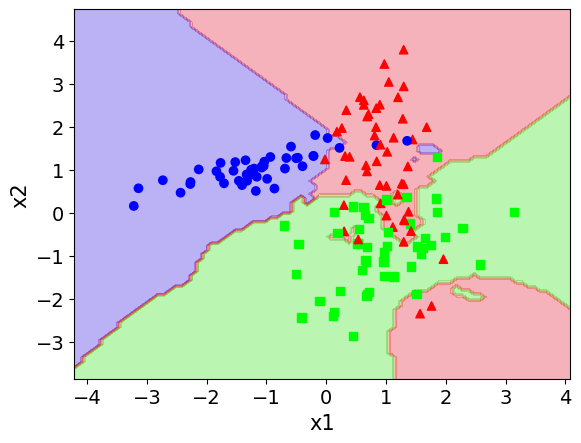

In [47]:
plot_decision_boundaries(X_train, y_train, KNNClassifier, k=3, p=2, verbose=False)
plt.show()

Utilizaremos a implementação do sklearn para obter mais velocidade e outras otimizações

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

In [50]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.predict(X_test)

array([1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 0, 0,
       2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 0, 2, 2, 2])

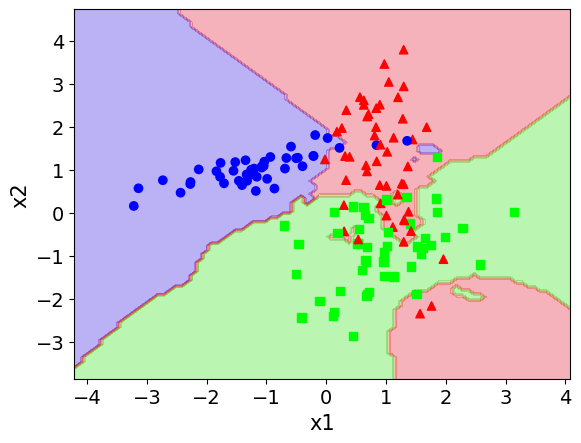

In [51]:
plot_decision_boundaries(X_train, y_train, KNeighborsClassifier, n_neighbors=3)
plt.show()


Foco nos seguintes exemplos:

- k = 50

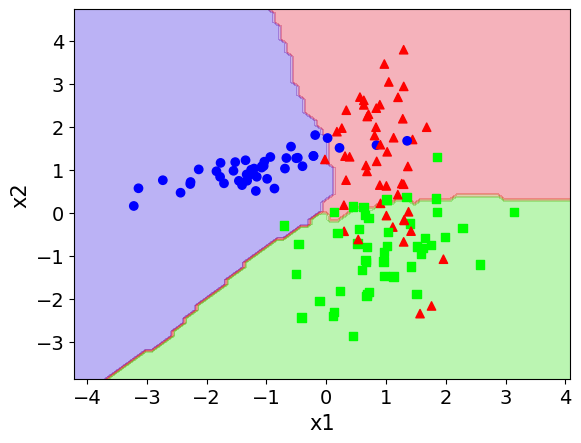

In [52]:
plot_decision_boundaries(X_train, y_train, KNeighborsClassifier, n_neighbors=50)
plt.show()

- k = 1

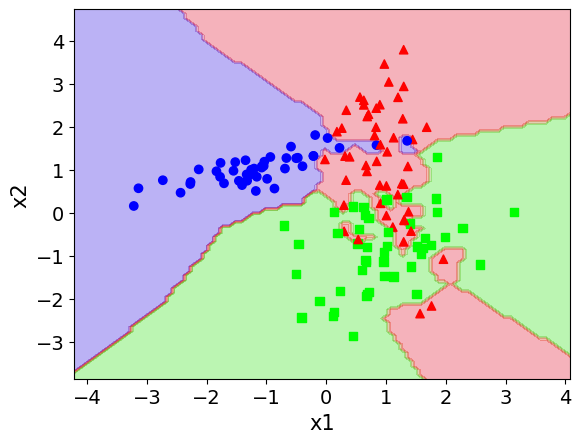

In [53]:
plot_decision_boundaries(X_train, y_train, KNeighborsClassifier, n_neighbors=1)
plt.show()

# 6. Algoritmos baseados em distância e a importância da escala

- Os dados que utilizamos até aqui possuem a mesma escala nos dados
- Mas e se esse não fosse o caso?

In [54]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=0
)

# Aumento a escala da primeira feature
X[:, 0] *= 100.0 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [55]:
cls = KNeighborsClassifier()
cls.fit(X_train, y_train)

KNeighborsClassifier()

In [56]:
print(metrics.classification_report(y_test, cls.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.59      0.56      0.57        18
           2       0.50      0.58      0.54        19

    accuracy                           0.65        60
   macro avg       0.65      0.64      0.64        60
weighted avg       0.66      0.65      0.65        60



In [57]:
vis = pd.DataFrame(X, columns=["x1", "x2"])
vis["Classe"] = y
vis["Classe"] = vis["Classe"].astype("category")

fig = px.scatter(
    vis, x="x1", y="x2", color="Classe", symbol="Classe")
fig.update_layout(
    autosize=False,
    width=600,
    height=500
)
fig.show()

E agora?

- Feature scaling!!
- Padronizamos as features para garantir que todas tenham a mesma importância para o modelo.
- Scaling é essencial para todo algoritmo baseado em distância
- Existem vários scalers disponíveis no sklearn
    - Vale a pena explorar a documentação
    - Soluções mais populares: `MinMaxScaler` (entre 0 e 1) e `StandardScaler` (z-score)
    - Min-Max:
        $$\tilde{x} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$$
   - z-score:
    $$\tilde{x} = \dfrac{x - \mu}{\sigma}$$
    - Para dados com outlier, z-score é uma escolha melhor

In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [59]:
cls = make_pipeline(StandardScaler(), KNeighborsClassifier())
cls.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [60]:
print(metrics.classification_report(y_test, cls.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.77      0.94      0.85        18
           2       0.94      0.89      0.92        19

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



In [61]:
sc = StandardScaler().fit(X)
transform = sc.transform(X)

In [62]:
np.mean(transform[:, 0]), np.std(transform[:, 0]) 

(-1.0658141036401502e-16, 0.9999999999999999)

# Em resumo:

- Vantagens k-NN:
    - Conceptualmente simples
    - Poucos hiperparâmetros para ajuste
    - Não possui um viés forte, tampouco variância
    - Pode lidar com qualquer métrica de distância
- Desvantagens:
    - Lazy: utilização pode ser custosa para uma base de dados grandes
        - Estruturas auxiliares são utilizadas para diminuir os custos. Ex: kd-Trees.
    - Maldição da dimensionalidade: quando o número de dimensões é muito alta, calcular distâncias é um problema
        - Solução: seleção de atributos e redução de dimensionalidade
- Principais hiperparâmetros:
    - Número de vizinhos: `n_neighbors`
    - Métrica de distância: `distance`


# Tarefa:

1. Descreva com suas palavras os fenômenos que estão acontecendo em cada um exemplos acima (com k=50 e k=1). Dica: comentamos durante a aula sobre esses problemas.


**R:**

2. Em problemas de classificação, é uma boa ideia utilizar valores ímpares para `k` no k-NN. Comente com as suas palavras sobre isso. Qual é o motivo dessa escolha?

**R:**